# 0- Introduction general

- Problematic

- Structure of the data

- Strategy

# 1- Importation of all necessary libraries and configuration of parameters

- Importation of libraries

In [1]:
#Module configuration
#from py2neo import Graph #Database connection
import neomodel
import pandas as pd
import datetime

- Configuration of database basic settings

In [2]:
from neomodel import config

neo4jServerAdress = "172.21.56.47"
neo4jConnectionPort = 7687  #Connection to server bolt
user= "neo4j" 
password= "Mypassword%2023"
config.DATABASE_URL='bolt://' +user + ':' + password + '@' + neo4jServerAdress + ':' + str(neo4jConnectionPort)

embeddingNbDimensions=20 # 3  # or None


In [3]:
from neomodel import (config, StructuredNode, StringProperty, IntegerProperty,DateTimeProperty,
                    DateTimeFormatProperty,UniqueIdProperty, RelationshipTo,StructuredRel)

config.DATABASE_URL='bolt://' +user + ':' + password + '@' + neo4jServerAdress + ':' + str(neo4jConnectionPort)

#NIP	J_Parcours	DateDebutActe	DateFinActe	UF	Service	Phase_Parcours	Activite	Dimension_Parcours	Ref_Acte	id_Sequence	Type_Sequence	id_sejour

class FOLLOWED_BY(StructuredRel):
    Nb_Days = IntegerProperty(index=True, default=0)
    NIP=StringProperty(required=False)

class Acte(StructuredNode):
    Ref_Acte = StringProperty(required=True)
    J_Parcours=IntegerProperty(required=True)
    Duree = IntegerProperty(required=True)
    UF = StringProperty(required=True)
    #Service = StringProperty(required=True)
    #Phase_Parcours =StringProperty(required=True)
    #Activite =StringProperty(required=True)
    #Dimension_Parcours = StringProperty(required=True)
    Nombre_actes=IntegerProperty(required=False, default=1)     
    Carepath = RelationshipTo('Acte', 'FOLLOWED_BY', model=FOLLOWED_BY)

class Patient(StructuredNode):
    NIP = StringProperty(unique_index=True, required=True)
    J0 = StringProperty(required=True)
    J_Parcours = IntegerProperty(required=False, default=0)
    Carepath = RelationshipTo('Acte', 'BEGIN_CAREPATH_WITH', model=FOLLOWED_BY)


- Some usefull functions

In [4]:
#Function to extract information from a row
date_format = '%Y-%m-%d %H:%M:%S.%f'

def extract_data(row):
    from datetime import datetime
    acte = {
        'Jp': row.get('J_Parcours', None),
        'DDA': datetime.strptime(row.get('DateDebutActe', None), date_format),
        'DDF': datetime.strptime(row.get('DateFinActe', None), date_format),
        'Ref': row.get('Ref_Acte', None),
        'NIP': row.get('NIP', None),
        'UFname': str(row.get('UF', None)),
        'service': row.get('Service', None),
        'phase_parcours': row.get('Phase_Parcours', None).replace(" ", ""),
        'activite': row.get('Activite', None),
        'dim_parcours': row.get('Dimension_Parcours', None),
        'Sequence_id': row.get('id_Sequence', None),
        'Sequence_Type': row.get('Type_Sequence', None),
        'Sejour_id': row.get('id_sejour', None)
    }

    return acte


#Define a query function
def myquery(query, params=None):
    from neomodel import db
    results, meta = db.cypher_query(query, params, resolve_objects=True)
    
    
    return results, meta

#Append to a node tuple

def myappend(alist,value):
    if not isinstance(alist, list):
        newlist=[alist]
    else:
        newlist=alist
    newlist.append(value)

    return newlist


#Define a function to create a new acte 
def create_acte(myActe):
    new_acte=Acte(
                    Ref_Acte = myActe['Ref'],
                    Duree = int((myActe['DDF'] - myActe['DDA']).total_seconds()),
                    J_Parcours = myActe['Jp'],
                    UF = myActe['UFname'],
                    #Service = myActe['service'],
                    #Phase_Parcours = myActe['phase_parcours'],
                    #Activite = myActe['activite'],
                    #Dimension_Parcours = myActe['dim_parcours'],
                ).save()
    return new_acte

def update_acte(myNodeActe, myNewActe):
    
    #Check if J_Parcours is th same between NodeActe and NewActe

    if myNodeActe.J_Parcours==myNewActe['Jp']:
        myNodeActe.Ref_Acte=myappend(myNodeActe.Ref_Acte,myNewActe['Ref'])
        myNodeActe.UF=myappend(myNodeActe.UF,myNewActe['UFname'])
        #myNodeActe.Service=myappend(myNodeActe.Service,myNewActe['service'])
        #myNodeActe.Phase_Parcours=myappend(myNodeActe.Phase_Parcours,myNewActe['phase_parcours'])
        #myNodeActe.Activite=myappend(myNodeActe.Activite,myNewActe['activite'])
        #myNodeActe.Dimension_Parcours=myappend(myNodeActe.Dimension_Parcours,myNewActe['dim_parcours'])
        myNodeActe.Nombre_actes=myNodeActe.Nombre_actes+1
        myNodeActe.save()
        
    else:
        raise (f"Error in Updating Node {myNodeActe.id}, the new Acte doesn't have the same J parcours !")

    return myNodeActe


def create_Startnode(myActe):
    startNode=Patient(
                    NIP = myActe['NIP'],
                    J0 = myActe['DDA']
                    ).save()
    return startNode

# 2- Importation of patient database and transformation into graphical database

- Importation of patient databases

In [5]:
# Define the filepath of the import csvfile
file_path = r'..\01_Datasets\Dataset_Simple_V0.csv'

#'..\01_Datasets\DL_Project_Dataset_Cluster2-243Patients_Encrypted.csv'
#'Dataset_Simple_V0.csv'
# Read the CSV file into a DataFrame
df = pd.read_csv(file_path, sep=';')
# Display the first few rows of the DataFrame
df

,NIP,J_Parcours,DateDebutActe,DateFinActe,UF,Service,Phase_Parcours,Activite,Dimension_Parcours,Ref_Acte,id_Sequence,Type_Sequence,id_sejour
0,NIP1,0,2019-01-02 00:00:00.000,2019-01-02 00:00:00.000,80,Med,Ph1,Ac1,Dim1,Ref1,Seq1,TSEQ1,IDSej1
1,NIP1,2,2019-01-04 00:00:00.000,2019-01-04 00:00:00.000,81,Med,Ph2,Ac2,Dim2,Ref2,Seq2,TSEQ2,IDSej2
2,NIP1,4,2019-01-06 00:00:00.000,2019-01-06 00:00:00.000,82,Med,Ph3,Ac3,Dim3,Ref3,Seq3,TSEQ3,IDSej3
3,NIP1,6,2019-01-08 00:00:00.000,2019-01-08 00:00:00.000,83,Med,Ph4,Ac4,Dim4,Ref4,Seq4,TSEQ4,IDSej4
4,NIP2,0,2019-02-02 00:00:00.000,2019-02-02 00:00:00.000,80,Med,Ph1,Ac1,Dim1,Ref1,Seq1,TSEQ1,IDSej7
5,NIP2,2,2019-02-04 00:00:00.000,2019-02-04 00:00:00.000,81,Med,Ph2,Ac2,Dim2,Ref2,Seq2,TSEQ2,IDSej8
6,NIP2,4,2019-02-06 00:00:00.000,2019-02-06 00:00:00.000,82,Med,Ph3,Ac3,Dim3,Ref3,Seq3,TSEQ3,IDSej9
7,NIP2,6,2019-02-08 00:00:00.000,2019-02-08 00:00:00.000,83,Med,Ph4,Ac4,Dim4,Ref4,Seq4,TSEQ4,IDSej10
8,NIP2,8,2019-02-10 00:00:00.000,2019-02-10 00:00:00.000,84,Med,Ph5,Ac5,Dim5,Ref5,Seq5,TSEQ5,IDSej11
9,NIP2,10,2019-02-12 00:00:00.000,2019-02-12 00:00:00.000,85,Med,Ph6,Ac6,Dim6,Ref6,Seq6,TSEQ6,IDSej12


In [6]:
#INITIALISATION   #CLEAR THE DATABASE
query="MATCH (n) DETACH DELETE n"
myquery(query)

Start=True
output=True

# Iterate over the rows of the DataFrame
for index, row in df.iterrows():
    # Extract values from the DataFrame
    myActe = extract_data(row)

    if Start:
        #Create a new acte
        new_acte=create_acte(myActe)
        Active_Node=new_acte
        
        #Create a start node
        startNode=create_Startnode(myActe)

        #LINK THE START NODE TO THE ACTES
        startNode.Carepath.connect(new_acte)
        Start=False

        #SET THE START NODE AS THE PREVIOUS NODE
        Previous_Node=startNode

    else:
        if oldActe['NIP']!=myActe['NIP']: #Check if we are dealing with the same patient
            #Create a new acte
            new_acte=create_acte(myActe)
            
            Active_Node=new_acte
            
            #Create a start node
            startNode=create_Startnode(myActe)

            #LINK THE START NODE TO THE ACTES
            startNode.Carepath.connect(new_acte)
            #SET THE START NODE AS THE PREVIOUS NODE
            Previous_Node=startNode

        else:            
            #Check if we have to change the previous node
            if myActe['Jp']!=oldActe['Jp']:
                #Create a new acte
                new_acte=create_acte(myActe)

                Previous_Node=Active_Node
                Active_Node=new_acte

                #LINK THE ACTE TO THE PREVIOUS ONE
                Previous_Node.Carepath.connect(new_acte, {'Nb_Days': myActe['Jp']-Previous_Node.J_Parcours ,'NIP': myActe['NIP'] })

            else:
                #update the active node
                new_acte=update_acte(Active_Node,myActe)
                #Active_Nodes.append(new_acte)

    #Store the acte in a variable oldActe
    oldActe=myActe

In [7]:
#List exsiting graph in the database
from neomodel import db
query = """
CALL gds.graph.list()
YIELD graphName, nodeCount, relationshipCount
RETURN graphName, nodeCount, relationshipCount
ORDER BY graphName ASC
"""
results = db.cypher_query(query)
results

#delete all existings graphs
for graph in results[0]:
    query = f"""
            CALL gds.graph.drop('{graph[0]}') YIELD graphName;
            """
    results = db.cypher_query(query)

In [8]:
#Node Embedings

#Create an in-Memory graph:
query = """
CALL gds.graph.project(
  'Mygraph',
  'Acte',
  'FOLLOWED_BY',
  {
    relationshipProperties: 'Nb_Days'
  }
)
"""
results = db.cypher_query(query)


In [9]:
# If you need to specify a number of dimension :
#CALL gds.node2vec.stream('Mygraph', {embeddingDimension: 2})
#If you don't need to specify a number of dimension:
#CALL gds.node2vec.stream('Mygraph')




#run the node2vec algorithm:
if embeddingNbDimensions==None:
    query = """
    CALL gds.node2vec.stream('Mygraph')
    YIELD nodeId, embedding
    RETURN nodeId, embedding
    """
else:
    query = f"""
    CALL gds.node2vec.stream('Mygraph', {{embeddingDimension: {embeddingNbDimensions}}})
    YIELD nodeId, embedding
    RETURN nodeId, embedding
    """

from neomodel import db
results = db.cypher_query(query)

nb_ebemdings_dimensions=len(results[0][0][1])

In [10]:
#convert the result variable into a dict
Dict_embedings = {}

for entry in results[0]:
    node_id = entry[0]
    embedding = entry[1]
    Dict_embedings[node_id] = {'Embedding': embedding}

- Analysis of patient data

In [11]:
# Python cell added

- Graphical modeling based on patient actions and pathways

In [12]:
# Python cell added

# 3- Generation of POC to verify project feasibility.

In [13]:
#GET THE LIST OF PATIENT IN THE DATABASE

query="""MATCH (n:Patient) RETURN n.NIP"""
list_of_NIPs = db.cypher_query(query)

In [14]:
#GET THE LIST OF NODES_ID OF THE CAREPATH OF EACH PATIENT

NIP_Carepath={}
max_Carepath_lenght=0

for i,nip in enumerate(list_of_NIPs[0],start=1):
    
    list_of_Nodes_ID=[]
    Partial_Carepath=[]

    query=f"""
        MATCH (n:Acte)-[l:FOLLOWED_BY]->(m:Acte)
        WHERE l.NIP='{nip[0]}'
        RETURN id(n) AS NodeID, id(m) AS RelatedNodeID
        ORDER BY NodeID asc
        """
    list_of_Nodes_ID = db.cypher_query(query)

    Carepath=[]
    for j,relation in enumerate(list_of_Nodes_ID[0],start=0):
        Carepath.append(relation[0])
        lastnode=relation[1]

        #Partial Carepath
        Partial_Carepath.append(Carepath.copy()) 

    #construct the list
    Carepath.append(lastnode)
    #Partial Carepath
    Partial_Carepath.append(Carepath.copy()) 


    #Add the carepath to the dict
    NIP_Carepath[i]={'NIP' : nip[0], 'Carepath' : Carepath, 'SampleCareMatrix' : Partial_Carepath}
    
    #udpate the max Carepath lenght
    if max_Carepath_lenght<len(Carepath) : max_Carepath_lenght=len(Carepath)

#NIP_Carepath

In [15]:
#Construct the SampleMatrix to a determined dimension and fill zeros at the left when dimension isn't enought

#determine the size of X (nb of columns)
#Maximum lenght of carepath in the database
nb_columns=max_Carepath_lenght

#or a definite value
#nb_columns=2

#Croop the matrix to the number of column defined
for key, value in NIP_Carepath.items():
    value['SampleCareMatrix'] = [sample[-nb_columns:] for sample in value['SampleCareMatrix']]

#Add zeros at the left when the size of the sampleCareMatrix is less than to the nb of column defined
for key, value in NIP_Carepath.items():
    for sample in value['SampleCareMatrix']:
        while len(sample) < nb_columns:
            sample.insert(0, 0)

#NIP_Carepath

In [16]:
nb_dim=nb_ebemdings_dimensions

#Create a SampleCareTensor from the SampleCareMatrix where NodeIds are replaced by their embedings
for key, value in NIP_Carepath.items():
    value['SampleCareTensor'] = []
    for CM_Index,NodeIds_List in enumerate(value['SampleCareMatrix'],start=0):
        my_Embedings=[]
        for NodesIds_index,val_NodeId in enumerate(NodeIds_List,start=0):
            if val_NodeId==0:
                my_Embedings.append([0] * nb_dim)
            else:
                my_Embedings.append(Dict_embedings[val_NodeId]['Embedding'])
        value['SampleCareTensor'].append(my_Embedings)
        

In [17]:
import numpy as np

#nb of columns is defined in a previous cell dedicated to #Construct the SampleMatrix

G_CP_matrix = np.empty((0, nb_columns))  # Initialize an empty matrix
CP_matrix = np.empty((0, nb_columns))  # Initialize an empty matrix

for index in NIP_Carepath : 
    My_CP_Vector = NIP_Carepath[index]['SampleCareTensor']
    CP_matrix = np.empty((0, nb_columns))  # Initialize an empty matrix

    for CP_item in My_CP_Vector:
        V = []
        for embedding in CP_item:
            V.append(np.transpose(embedding))

        matrix = np.column_stack(V)
        CP_matrix = np.vstack((CP_matrix, matrix))

    G_CP_matrix = np.vstack((G_CP_matrix, CP_matrix))

- Prediction with linear model using machine learning

In [18]:
# CREATE X, Y TRAIN AND TEST SAMPLES

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Scale the features to have values between 0 and 1
scaler = MinMaxScaler()
G_scaled = scaler.fit_transform(G_CP_matrix)


# G_CP_matrix contains features (X) and labels (Y)
X = G_scaled[:, :-1]  # Extract all columns except the last one from G_CP_matrix 
Y = G_scaled[:, -1]   # Extract the last column from G_CP_matrix

# Split data into training and testing sets for both features and labels
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Verify shapes of the datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (784, 7)
X_test shape: (196, 7)
Y_train shape: (784,)
Y_test shape: (196,)


In [19]:
from sklearn import feature_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

random_state = 42

#LINEAR REGRESSION
linreg = LinearRegression()
linreg.fit(X_train, Y_train)
linreg_pred = linreg.predict(X_test)
linreg_score = round(linreg.score(X_test, Y_test), 4)

#DECISION TREE
tree = DecisionTreeRegressor(max_depth=5, random_state=random_state)
tree.fit(X_train, Y_train)
tree_pred = tree.predict(X_test)
tree_score = round(tree.score(X_test, Y_test), 4)
#print(f"Linear Regression score : {linreg_score}\nDecision Tree score : {tree_score}")

#RANDOMFOREST
forest = RandomForestRegressor(max_depth=5, oob_score=True, random_state=random_state)
forest.fit(X_train, Y_train)
forest_pred = forest.predict(X_test)
forest_score = round(forest.score(X_test, Y_test), 4)


#print(f"Linear Regression score : {linreg_score}\nDecision Tree score : {tree_score}")
#print(f"Random Forest score : {forest_score}")

#RETURN SCORES
print(f"Linear Regression score : {linreg_score}\nDecision Tree score : {tree_score}")
print(f"Random Forest score : {forest_score}\n")

Linear Regression score : 0.0045
Decision Tree score : -0.0981
Random Forest score : 0.0602



In [20]:
from sklearn import metrics
def regression_metrics(y_true, y_pred, form=':.4d'):
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    rmsle = np.sqrt(metrics.mean_squared_log_error(y_true, y_pred))
    r2 = metrics.r2_score(y_true, y_pred)
    print(f"RMSE : {rmse:.4f}\nMSE : {mse:.4f}\nMAE : {mae:.4f}\nR2 : {r2:.4f}\nRMSLE : {rmsle:.4f}")

model_pred_dic = {'Linear Regression': linreg_pred,
                'Decision Tree': tree_pred,
                'Random Forest': forest_pred
                }
for model, preds in model_pred_dic.items():
    print(model)
    regression_metrics(Y_test, preds)
    print('-'*30)

Linear Regression
RMSE : 0.2490
MSE : 0.0620
MAE : 0.2077
R2 : 0.0045
RMSLE : 0.1688
------------------------------
Decision Tree
RMSE : 0.2616
MSE : 0.0684
MAE : 0.2160
R2 : -0.0981
RMSLE : 0.1779
------------------------------
Random Forest
RMSE : 0.2420
MSE : 0.0585
MAE : 0.2005
R2 : 0.0602
RMSLE : 0.1644
------------------------------


- Result

In [21]:
# Python cell added

- Evaluation

In [22]:
# Python cell added

- Prediction with RNN models and optimization of results

In [23]:
#Module configuration
#from py2neo import Graph #Database connection
import neomodel
import pandas as pd
import datetime
import numpy as np
import torch
import torch.nn as nn
import random
import os

In [24]:
#Config
# Parameters :
#Structuration of the acte in the graph database -> See directly in the cell
#Nb of Embedings dimensions in Node2vec:
#embeddingNbDimensions=3

#Size of the Carepath extraction
def size_of_CP_to_learn(Maxlength):
    size = int(Maxlength*0.6)
    #size = 10
    return size

n_hidden = 40
lr=0.01
criterion = nn.MSELoss()  # Suitable loss function

#nn.NLLLoss()  nn.CrossEntropyLoss() nn.MSELoss()

myFileName='DL_Project_Dataset_Sample_V5.csv'
#'DataCP_Example/CP_Category_1.csv'
#DL_Project_Dataset_Sample_V5.csv
#'Dataset_Simple_V0.csv'
#'DL_Project_Dataset_LongCP_Cluster1-772Patients.csv'
renew_database=True

In [25]:
#add a zero acte at index zero
Dict_embedings[0] = {'Embedding': np.zeros(nb_ebemdings_dimensions) }

In [26]:
print(f'Dict_embedings contains {len(Dict_embedings)} items with {nb_ebemdings_dimensions} embedings dimensions each' )

Dict_embedings contains 50 items with 20 embedings dimensions each


In [27]:
#GET THE LIST OF NODES_ID OF THE CAREPATH OF EACH PATIENT

NIP_Carepath={}
max_Carepath_lenght=0

for i,nip in enumerate(list_of_NIPs[0],start=1):
    
    list_of_Nodes_ID=[]
    Partial_Carepath=[]

    query=f"""
        MATCH (n:Acte)-[l:FOLLOWED_BY]->(m:Acte)-[ll:FOLLOWED_BY]->(p:Acte)
        WHERE  l.NIP='{nip[0]}' AND ll.NIP='{nip[0]}'
        RETURN id(n) AS NodeID, id(m) AS RelatedNodeID , min(l.Next_Acte_from_JP) AS fromJP
        ORDER BY fromJP, NodeID
        """
    list_of_Nodes_ID = db.cypher_query(query)

    Carepath=[]
    for j,relation in enumerate(list_of_Nodes_ID[0],start=0):
        Carepath.append(relation[0])
        lastnode=relation[1]

        #Partial Carepath
        if len(Carepath)>1 :
            Partial_Carepath.append(Carepath.copy())

    #construct the list
    Carepath.append(lastnode)
    
    #Partial Carepath
    Partial_Carepath.append(Carepath.copy())


    #Add the carepath to the dict
    NIP_Carepath[i]={'NIP' : nip[0], 'Carepath' : Carepath, 'SampleCareMatrix' : Partial_Carepath}
    
    #udpate the max Carepath lenght
    if max_Carepath_lenght<len(Carepath) : max_Carepath_lenght=len(Carepath)

#NIP_Carepath

In [28]:
#Construct the SampleMatrix to a determined dimension and fill zeros at the left when dimension isn't enought

#determine the size of X (nb of columns)
#Maximum lenght of carepath in the database
nb_columns=size_of_CP_to_learn(max_Carepath_lenght)
#nb_columns=2

#or a definite value
#nb_columns=2

#Croop the matrix to the number of column defined
for key, value in NIP_Carepath.items():
    value['SampleCareMatrix'] = [sample[-nb_columns:] for sample in value['SampleCareMatrix']]

#Add zeros at the left when the size of the sampleCareMatrix is less than to the nb of column defined
for key, value in NIP_Carepath.items():
    for sample in value['SampleCareMatrix']:
        while len(sample) < nb_columns:
            sample.insert(0, 0)

#NIP_Carepath

In [29]:
#Let's construct a function Vec_to_Node in order to construct the prevision of carepath.

#function Vec_2_node
def Vec_2_node(query_vector, embeddings):
    closest_node_id = None
    closest_distance = float('inf')
    
    for node_id, node_embedding in embeddings.items():
        embedding_vector = node_embedding['Embedding']

        query_array = np.array(query_vector)
        embedding_array = np.array(embedding_vector)

        distance = np.linalg.norm(query_array - embedding_array)  # Euclidean distance
        if distance < closest_distance:
            closest_distance = distance
            closest_node_id = node_id
            
    return closest_node_id

In [30]:
nb_NIP=len(NIP_Carepath)
my_NIP_indexes_list = [i for i in range(1, nb_NIP+1)]

In [31]:
# PREPARE X AND Y SETS
split = 0.5

training = {}
testing = {}

print('ordered')
print(my_NIP_indexes_list)
random.shuffle(my_NIP_indexes_list)  # Shuffle the Carepath list
print('shuffled')
print(my_NIP_indexes_list)

split_index = int(len(my_NIP_indexes_list) * split)

training_ids = my_NIP_indexes_list[:split_index]
testing_ids = my_NIP_indexes_list[split_index:]

print('training')
print(training_ids)

print('test')
print(testing_ids)

ordered
[1, 2, 3, 4, 5, 6, 7, 8]
shuffled
[1, 6, 8, 2, 5, 3, 7, 4]
training
[1, 6, 8, 2]
test
[5, 3, 7, 4]


In [32]:
def carepath_to_tensor(carepath):
    """Convert a name into a matrix where each row one-hot encodes a character."""
    tensor = torch.zeros(len(carepath), nb_ebemdings_dimensions)
    for idx, acte in enumerate(carepath):
        tensor[idx] = torch.tensor(Dict_embedings[acte]['Embedding'])
    return tensor

In [33]:
def ids_to_tensor(list_NIP_ids):
    
    Training_NIP_tensors=[]
    
    for id_NIP in list_NIP_ids:
        
        Training_tensors=[]
        for carepathsample_index in range(len(NIP_Carepath[id_NIP]['SampleCareMatrix'])):
            #print(NIP_Carepath[id_NIP]['SampleCareMatrix'][carepathsample_index])
            #print('Associated Tensor')
            tensor=carepath_to_tensor(NIP_Carepath[id_NIP]['SampleCareMatrix'][carepathsample_index])
            #print(tensor)
            Training_tensors.append(tensor)

    # Concatenate the tensors along dimension 0
    #Training_tensor = torch.stack(Training_tensors, dim=0)
        Training_NIP_tensors.append(Training_tensors)

    return Training_NIP_tensors

In [34]:
Training   = ids_to_tensor(training_ids)
Testing     = ids_to_tensor(testing_ids)

In [35]:
#From Training/Test Tensor to Input/Output

def TrainTest_to_InputOutput(CP_Tensor):
    
    # Number of elements per new tensor
    elements_per_tensor = len(CP_Tensor[0])

    # Splitting each tensor
    input_tensor = []
    output_tensor=[]
    for tensor in CP_Tensor:
        input_tensor.append(tensor[0:elements_per_tensor-1])
        output_tensor.append(tensor[1:elements_per_tensor])
    
    #Flatening input and output tensor
    Flat_input_tensor=[tensor.flatten() for tensor in input_tensor]
    Flat_output_tensor=[tensor.flatten() for tensor in output_tensor]

    return Flat_input_tensor, Flat_output_tensor

- Configuration of the GPU

In [36]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


- RNN Parameters

In [37]:
#RNN Parameters :
inputsize  =  (size_of_CP_to_learn(max_Carepath_lenght)-1) * nb_ebemdings_dimensions
outputsize = (size_of_CP_to_learn(max_Carepath_lenght)-1) * nb_ebemdings_dimensions

print(f'Input size = {inputsize} , Hidden size = {n_hidden} , Output size = {outputsize}')

Input size = 60 , Hidden size = 40 , Output size = 60


In [38]:
class RNN(nn.Module):
    "Simple RNN architecture that explicitly accepts its hidden state."
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.hidden_size = hidden_size

        combined_size = input_size + hidden_size
        self.i2h = nn.Linear(combined_size, hidden_size)
        self.i2o = nn.Linear(combined_size, output_size)
        #self.softmax = nn.LogSoftmax(dim=0)

    def forward(self, input, hidden):
        "Forward pass for a given input tensor and hidden state."
        combined = torch.cat((input, hidden))
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        #output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        "Create a new hidden state for a new name."
        return torch.zeros(self.hidden_size)

In [39]:
def train(rnn,tensor,criterion,optimizer, lr):
    hidden = rnn.init_hidden()
    rnn.zero_grad() #reset gradient computations.

    indexes=len(tensor)
    Input_tensor,Target_tensor = TrainTest_to_InputOutput(tensor)
    loss=0

    for i in range(indexes):
        #print(f'i = {i}')
        #print(f'INPUT = {Input_tensor[i]}')
        #print(f'HIDDEN = {hidden}')
        #print(f'OUTPUT = {Target_tensor[i]}')
        #print('end of itteration')

        output,hidden = rnn(Input_tensor[i],hidden)
        l= criterion(output,Target_tensor[i])
        loss += l

    loss.backward() #computes gradients

    # Calculate accuracy

    # Tweak the network's parameters slightly! (aka, teach the network!)
    #for p in rnn.parameters():
    #    p.data.add_(p.grad.data, alpha=-lr)
    optimizer.step()  # Update parameters based on gradients

    return output, loss #, accuracy

In [40]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    it=random.randint(0,len(Training)-1)
    return Training[it]

In [41]:
import time


Nb_batch_of_CP = len(Training)
#n_iters = Nb_batch_of_CP
n_iters = 1000
PRINT_EVERY = int(n_iters/50)+1
LOG_EVERY = int(n_iters/50)+1

# Keep track of losses for plotting.
current_loss = 0
all_losses = []


def time_since(since):
    """Return a pretty string with time elapsed."""
    now = time.time()
    s = now - since
    m, s = divmod(s, 60)
    return f"{int(m)}m {s:.2f}s"

rnn = RNN(inputsize, n_hidden, outputsize)
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

#hidden = rnn.init_hidden()
start = time.time()

for it in range(0, n_iters):
    #print(f'batch n° {it}')
    output, loss = train(rnn, randomTrainingExample(),criterion,optimizer,lr)
    #output, loss = train(rnn, Training[it],criterion,optimizer,lr)
    current_loss += loss

    if it % LOG_EVERY == 0:

        # Print current progress.
        avg_loss = current_loss / LOG_EVERY
        print(f"{round(100 * (it+1) / n_iters,3)}% ({time_since(start)}) // Loss = {avg_loss:.4f} // Itteration : {it+1} / {n_iters}")
        
        # Save average loss for plotting.
        all_losses.append(avg_loss)
        current_loss = 0

0.1% (0m 0.04s) // Loss = 0.0008 // Itteration : 1 / 1000
2.2% (0m 0.11s) // Loss = 0.0018 // Itteration : 22 / 1000
4.3% (0m 0.17s) // Loss = 0.0003 // Itteration : 43 / 1000
6.4% (0m 0.22s) // Loss = 0.0002 // Itteration : 64 / 1000
8.5% (0m 0.27s) // Loss = 0.0001 // Itteration : 85 / 1000
10.6% (0m 0.32s) // Loss = 0.0000 // Itteration : 106 / 1000
12.7% (0m 0.37s) // Loss = 0.0000 // Itteration : 127 / 1000
14.8% (0m 0.43s) // Loss = 0.0000 // Itteration : 148 / 1000
16.9% (0m 0.50s) // Loss = 0.0000 // Itteration : 169 / 1000
19.0% (0m 0.55s) // Loss = 0.0000 // Itteration : 190 / 1000
21.1% (0m 0.60s) // Loss = 0.0000 // Itteration : 211 / 1000
23.2% (0m 0.65s) // Loss = 0.0000 // Itteration : 232 / 1000
25.3% (0m 0.70s) // Loss = 0.0000 // Itteration : 253 / 1000
27.4% (0m 0.75s) // Loss = 0.0000 // Itteration : 274 / 1000
29.5% (0m 0.80s) // Loss = 0.0000 // Itteration : 295 / 1000
31.6% (0m 0.84s) // Loss = 0.0000 // Itteration : 316 / 1000
33.7% (0m 0.89s) // Loss = 0.0000 /

In [42]:
# Save the trained model
torch.save(rnn.state_dict(), 'trained_model.pth')

- Result

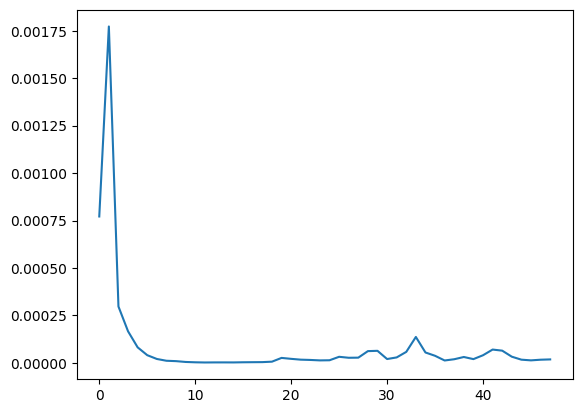

In [43]:
# Convert each tensor to a scalar
loss_list = [tensor.item() for tensor in all_losses]

import matplotlib.pyplot as plt

plt.figure()
plt.plot(loss_list)

- Evaluation

In [44]:
# Python cell added

- Prediction

In [45]:
def Get_InputTensor_from_idNode(idNode):

    InputTensorDim = embeddingNbDimensions * (size_of_CP_to_learn(max_Carepath_lenght)-2)

    # Create an empty flat tensor of size (15,)
    Input_tensor = torch.zeros(InputTensorDim )

    #Define the star letter
    start_letter=carepath_to_tensor([idNode])
    start_letter=[tensor.flatten() for tensor in start_letter][0]

    # Append the values from star_letter tensor to the Input_tensor
    Input_tensor = torch.cat((Input_tensor, start_letter), dim=0)

    return Input_tensor

In [46]:
#PREDICT STEP
max_length = 50

# Sample from a category and starting letter
def sample(start_id):
    Predicted_Carepath=[start_id]
    with torch.no_grad():  # no need to track history in sampling
        input = Get_InputTensor_from_idNode(start_id)
        hidden = rnn.init_hidden()

        for i in range(max_length):
            output, hidden = rnn(input, hidden)
            Next_Acte=output[-3:].tolist()
            #Get the last Node from output 
            closest_node_id = Vec_2_node(Next_Acte, Dict_embedings)
            Predicted_Carepath.append(closest_node_id)
            if closest_node_id==End_acteid:
                break
            input=output

        return Predicted_Carepath

In [47]:
sample(50)

KeyError: 50

# 4- General Conclusion